In [1]:
#Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import pandas as pd
import os


## Introducction

This code is designed to build and train a CNN (Convolutional Neural Network) for image classification using PyTorch. It starts by preparing image data with standard transformations and sets up datasets and loaders for efficient processing. The neural network architecture, defined as "ImageMulticlassClassificationNet", includes convolutional and fully connected layers to process images and make predictions.

During training, the model learns from data by adjusting its parameters using the Adam optimizer and cross-entropy loss function. Evaluation metrics like accuracy, loss, precision, recall, and F1-score are calculated and presented to assess how well the model performs on test data. Additionally, the code allows for single-image inference, demonstrating how the model predicts classes for new images after preprocessing. 

A graphical representation of the model's architecture (model_graph.png) is also generated using torchviz, providing a visual understanding of its structure.

In [2]:
#Acces to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [80]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)  # Sets the seed for generating random numbers on the CPU.

torch.cuda.manual_seed_all(seed)  # Sets the seed for all GPUs (if CUDA is enabled).
# By setting these seeds, random operations on GPUs also produce deterministic results.

torch.backends.cudnn.deterministic = True
# Ensures CuDNN uses deterministic algorithms for convolution operations,
# producing consistent results for the same input and parameters.

torch.backends.cudnn.benchmark = False
# Disables CuDNN's benchmark mode, which selects the best convolution algorithms
# based on hardware performance. This ensures reproducibility but may result in
# slower performance compared to benchmark mode.


#### Data processing
The process of transforming and loading data for deep learning involves several steps to prepare images for training a model. First, images are resized to a consistent size (e.g., 128x128 pixels) so that the model receives uniform inputs. Random horizontal flips and rotations introduce variations in the training data, helping the model learn to recognize objects from different angles.

Images are converted into a format called tensors, which are essential for performing calculations in deep learning. Normalization adjusts the pixel values of these tensors to a standard scale, making training more stable and efficient.

Finally, the transformed data is organized into batches and loaded using data loaders. These loaders handle tasks like shuffling the data for randomness and using multiple workers to speed up data processing. Overall, these steps ensure that the data is well-prepared and optimized for training deep learning models effectively.

In [64]:
# Transform and load data
# Set up image transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,),(0.5))  # Normalize the image tensor with mean 0.5 and standard deviation 0.5
])

# Set up train and test datasets
batch_size = 32
train_dataset = torchvision.datasets.ImageFolder(root="train", transform=transform)  # Load training dataset with transformations
test_dataset = torchvision.datasets.ImageFolder(root="test", transform=transform)  # Load testing dataset with transformations

# Set up data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)  # Data loader for training data
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)  # Data loader for testing data


In [65]:
# Get the class names and count the number of classes
# List and sort the subdirectory names in the "train" folder
CLASSES = sorted([name for name in os.listdir("train") if os.path.isdir(os.path.join("train", name))])  
NUM_CLASSES = len(CLASSES)  # Count the number of  classes



### The ImageMulticlassClassificationNet class

This is a blueprint for a neural network designed to classify images into multiple categories. Its purpose is to systematically transform input images through a series of specialized layers, each serving a distinct role in the image classification process.

At its core, the class integrates convolutional layers (conv1, conv2, conv3) to extract meaningful features from images. These layers use learnable filters to identify patterns such as edges, textures, and shapes. By applying successive convolution operations, the network progressively refines its understanding of the visual content within the images.

Following each convolutional layer, MaxPooling layers (pool) downsample the feature maps, focusing on the most significant information while reducing computational complexity. This step enhances the network's ability to recognize features invariant to small translations or distortions within the images.

To prevent overfitting and promote generalization, Dropout layers (dropout) randomly deactivate a fraction of neurons during training. This regularization technique encourages the network to rely on diverse sets of features, thereby improving its robustness and performance on unseen data.

The Flatten layer consolidates the multidimensional output of the convolutional layers into a single vector format, facilitating seamless integration with fully connected layers (fc1, fc2, fc3). These layers act as classifiers, leveraging the extracted features to make predictions about which category an image belongs to.

Throughout the network, ReLU activation functions (relu) introduce non-linearities, enabling the model to capture complex relationships between features. At the output layer, LogSoftmax activation (softmax) transforms the raw model outputs into probabilities, representing the likelihood of each image belonging to different classes.

By orchestrating these components in a structured manner, the ImageMulticlassClassificationNet class provides a systematic approach to image classification, aiming to achieve accurate and reliable predictions across diverse datasets.

In [66]:
# Define the model
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)  # First convolutional layer: input channels = 3, output channels = 32, kernel size = 3
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer with kernel size and stride of 2; halves the dimensions
        self.conv2 = nn.Conv2d(32, 64, 3)  # Second convolutional layer: input channels = 32, output channels = 64, kernel size = 3
        self.conv3 = nn.Conv2d(64, 128, 3)  # Third convolutional layer: input channels = 64, output channels = 128, kernel size = 3
        self.dropout = nn.Dropout(0.1)  # Dropout layer with a dropout probability of 0.1
        self.flatten = nn.Flatten()  # Flatten layer to convert 2D image arrays into 1D vectors
        self.fc1 = nn.Linear(128 * 14 * 14, 512)  # First fully connected layer: input features = 128*14*14, output features = 512
        self.fc2 = nn.Linear(512, 256)  # Second fully connected layer: input features = 512, output features = 256
        self.fc3 = nn.Linear(256, NUM_CLASSES)  # Third fully connected layer: input features = 256, output features = NUM_CLASSES (number of classes)
        self.relu = nn.ReLU()  # ReLU activation function
        self.softmax = nn.LogSoftmax(dim=1)  # LogSoftmax activation function along dimension 1 (log-probabilities over classes)

    def forward(self, x):
        x = self.conv1(x)  # Apply first convolutional layer; output: (BS, 32, 126, 126)
        x = self.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply max pooling; output: (BS, 32, 63, 63)
        x = self.dropout(x)  # Apply dropout

        x = self.conv2(x)  # Apply second convolutional layer; output: (BS, 64, 61, 61)
        x = self.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply max pooling; output: (BS, 64, 30, 30)
        x = self.dropout(x)  # Apply dropout

        x = self.conv3(x)  # Apply third convolutional layer; output: (BS, 128, 28, 28)
        x = self.relu(x)  # Apply ReLU activation
        x = self.pool(x)  # Apply max pooling; output: (BS, 128, 14, 14)
        x = self.dropout(x)  # Apply dropout

        x = self.flatten(x)  # Flatten the tensor

        x = self.fc1(x)  # Apply first fully connected layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.dropout(x)  # Apply dropout

        x = self.fc2(x)  # Apply second fully connected layer
        x = self.relu(x)  # Apply ReLU activation
        x = self.dropout(x)  # Apply dropout

        x = self.fc3(x)  # Apply third fully connected layer
        x = self.softmax(x)  # Apply LogSoftmax activation

        return x  



## Training proccess

Firts its initializes the model and moves it to the GPU (device), facilitating accelerated computation. A cross-entropy loss function (nn.CrossEntropyLoss()) is defined to quantify the discrepancy between predicted and actual class labels during training.

An Adam optimizer (torch.optim.Adam) is employed to adjust the model's parameters based on gradients computed during backpropagation, using a learning rate (lr) of 0.0001 to regulate the size of parameter updates. This combination optimizes the model's ability to learn from the dataset.

During the training phase, the model is set to train() mode, enabling the layers like dropout to function optimally by modifying their behavior based on the model's training state. The training process involves iterating over batches of data (trainloader), computing predictions (outputs), and calculating the loss compared to the ground truth labels (labels). Backpropagation computes gradients, which the optimizer then utilizes to update model parameters, incrementally refining its ability to classify images accurately.

The model's performance is evaluated after each epoch on a separate test dataset (testloader) to assess its generalization ability. In evaluation mode (eval()), gradients are disabled to conserve computational resources and ensure that only forward propagation occurs. Metrics such as loss and accuracy are computed for both training and test sets, providing insight into the model's learning progress and performance across epochs.

This systematic approach aims to iteratively enhance the model's accuracy and reliability in classifying images while leveraging GPU acceleration for efficient computation, demonstrating a structured methodology for deep learning model development and evaluation.

In [68]:
# Instantiate model, loss function, optimizer
model = ImageMulticlassClassificationNet().to(device)  # Move the model to the GPU
loss_fn = nn.CrossEntropyLoss()  # Define the loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # Define the optimizer with a learning rate of 0.0001

# Training and evaluation
NUM_EPOCHS = 100
train_loss_history = []  # List to store training loss values
train_acc_history = []  # List to store training accuracy values
test_loss_history = []  # List to store test loss values
test_acc_history = []  # List to store test accuracy values

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    train_correct = 0
    total_train = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        
        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the model parameters
        
        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
        train_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_train += labels.size(0)  # Count total number of labels
    
    epoch_train_loss = running_loss / len(trainloader)  # Calculate average training loss
    train_loss_history.append(epoch_train_loss)  # Append to the training loss history
    train_accuracy = 100 * train_correct / total_train  # Calculate training accuracy
    train_acc_history.append(train_accuracy)  # Append to the training accuracy history
    
    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_running_loss = 0.0
    test_correct = 0
    total_test = 0
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)  # Move data to the GPU

            outputs = model(images)  # Forward pass
            loss = loss_fn(outputs, labels)  # Compute the loss
            test_running_loss += loss.item()  # Accumulate the loss
            
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            test_correct += (predicted == labels).sum().item()  # Count correct predictions
            total_test += labels.size(0)  # Count total number of labels
            y_true.extend(labels.tolist())  # Store true labels
            y_pred.extend(predicted.tolist())  # Store predicted labels
    
    epoch_test_loss = test_running_loss / len(testloader)  # Calculate average test loss
    test_loss_history.append(epoch_test_loss)  # Append to the test loss history
    test_accuracy = 100 * test_correct / total_test  # Calculate test accuracy
    test_acc_history.append(test_accuracy)  # Append to the test accuracy history
    torch.cuda.empty_cache()  # Clear GPU cache

    # Print progress
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')



Epoch 1/100, Train Loss: 1.6723, Train Acc: 28.07%, Test Loss: 1.5050, Test Acc: 42.00%
Epoch 2/100, Train Loss: 1.4467, Train Acc: 42.53%, Test Loss: 1.3637, Test Acc: 50.17%
Epoch 3/100, Train Loss: 1.3447, Train Acc: 46.97%, Test Loss: 1.2917, Test Acc: 52.00%
Epoch 4/100, Train Loss: 1.2425, Train Acc: 53.07%, Test Loss: 1.2126, Test Acc: 56.17%
Epoch 5/100, Train Loss: 1.1441, Train Acc: 56.67%, Test Loss: 1.0806, Test Acc: 60.17%
Epoch 6/100, Train Loss: 1.0378, Train Acc: 61.93%, Test Loss: 1.0400, Test Acc: 63.17%
Epoch 7/100, Train Loss: 0.9282, Train Acc: 66.40%, Test Loss: 0.9604, Test Acc: 67.50%
Epoch 8/100, Train Loss: 0.8494, Train Acc: 70.10%, Test Loss: 0.9174, Test Acc: 67.50%
Epoch 9/100, Train Loss: 0.7592, Train Acc: 73.37%, Test Loss: 0.8336, Test Acc: 72.50%
Epoch 10/100, Train Loss: 0.6761, Train Acc: 77.23%, Test Loss: 0.7795, Test Acc: 73.00%
Epoch 11/100, Train Loss: 0.5897, Train Acc: 80.30%, Test Loss: 0.6432, Test Acc: 77.83%
Epoch 12/100, Train Loss: 0.56

### Precision, recall, and F1-score metrics for each class 

These metrics quantify the model's performance across different classes, providing insights into its ability to correctly identify instances of each class while managing false positives and negatives.

First, the precision_recall_fscore_support function from scikit-learn calculates precision, recall, and F1-score for each class separately (average=None). These metrics assess how well the model distinguishes each class among all instances predicted as that class (precision), correctly identifies all instances of a class among all actual instances of that class (recall), and balances precision and recall into a single score (F1-score).

Next, the results are organized into a pandas DataFrame (metrics_df), where each row corresponds to a class and columns represent precision, recall, and F1-score. This structured format facilitates easy manipulation and visualization of the metrics.

To enhance interpretability and comparison, the DataFrame is then melted (metrics_df.melt()) to transform it into a long format, making it suitable for visualization with Seaborn. The resulting DataFrame (metrics_df) is plotted using a bar plot (sns.barplot), where each class is represented by bars colored according to the metric (precision, recall, F1-score). This visualization helps in comparing the model's performance across different classes visually.

Overall, this process provides a comprehensive assessment of the model's classification performance on a per-class basis, aiding in identifying strengths and weaknesses across different categories of the dataset.

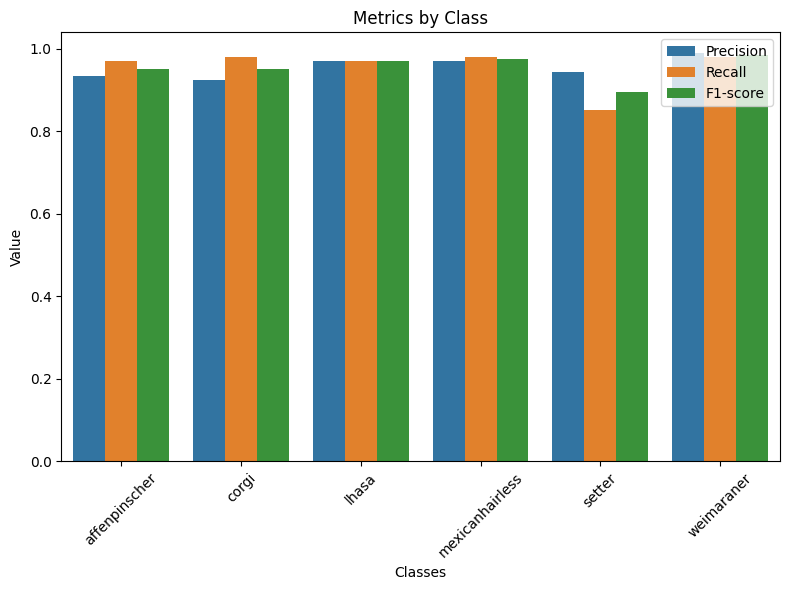

In [69]:
# Calculate precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Create a DataFrame with the metrics
metrics_df = pd.DataFrame({
    'Class': CLASSES,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1_score
})

# Melt the DataFrame to facilitate use with Seaborn
metrics_df = metrics_df.melt(id_vars='Class', var_name='Metric', value_name='Value')

# Plot the metrics with Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=metrics_df, x='Class', y='Value', hue='Metric')  # Create a bar plot with Seaborn
plt.xlabel('Classes')  # Label for x-axis
plt.ylabel('Value')  # Label for y-axis
plt.title('Metrics by Class')  # Title of the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()  # Display legend
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()  # Show the plot


#### Visualizations to evaluate the performance of a machine learning model trained for image classification:

* Confusion Matrix: This heatmap (sns.heatmap) visualizes the confusion matrix (cm) computed using the true (y_true) and predicted (y_pred) labels. Each cell in the heatmap represents the number of predictions where rows correspond to true classes and columns to predicted classes. Annotations (annot=True) display the numerical values in each cell. The colormap (cmap='Blues') indicates the intensity of correct predictions, with lighter shades representing higher values. Axes labels and title (plt.xlabel, plt.ylabel, plt.title) provide context to interpret the matrix.

* Accuracy and Loss Plots: Accuracy Plot displays the training and test accuracy (train_acc_history, test_acc_history) across epochs (range(1, NUM_EPOCHS + 1)). This line plot (plt.plot) shows the progression of accuracy over training epochs. The x-axis (Epoch) indicates the training iteration, while the y-axis (Accuracy (%)) measures the percentage of correctly predicted instances.
Loss Plot: Illustrates the training and test loss (train_loss_history, test_loss_history) over epochs. Loss metrics quantify the model's prediction error during training and evaluation. The plot helps monitor convergence (plt.plot), with epochs on the x-axis and loss values (Loss) on the y-axis.


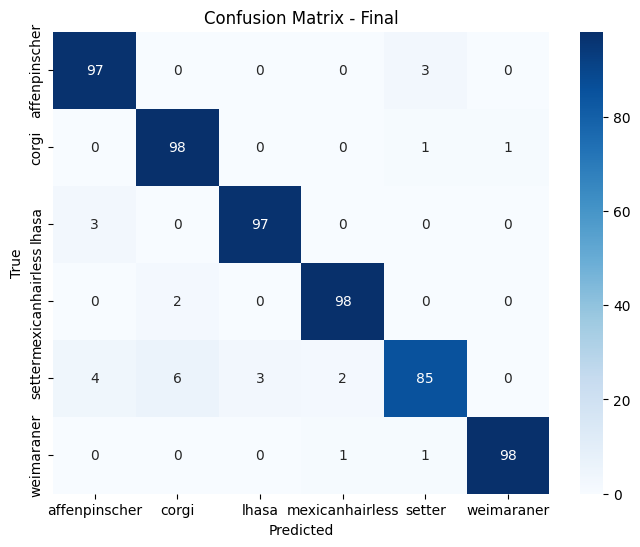

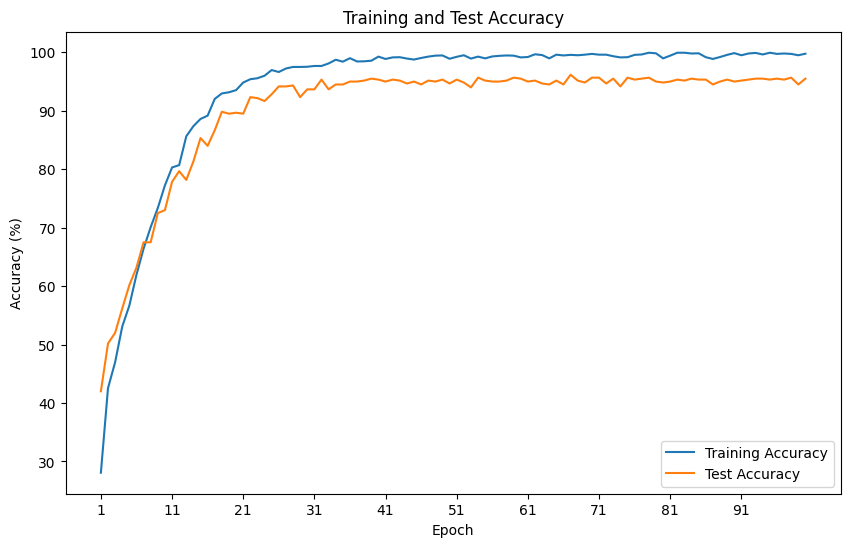

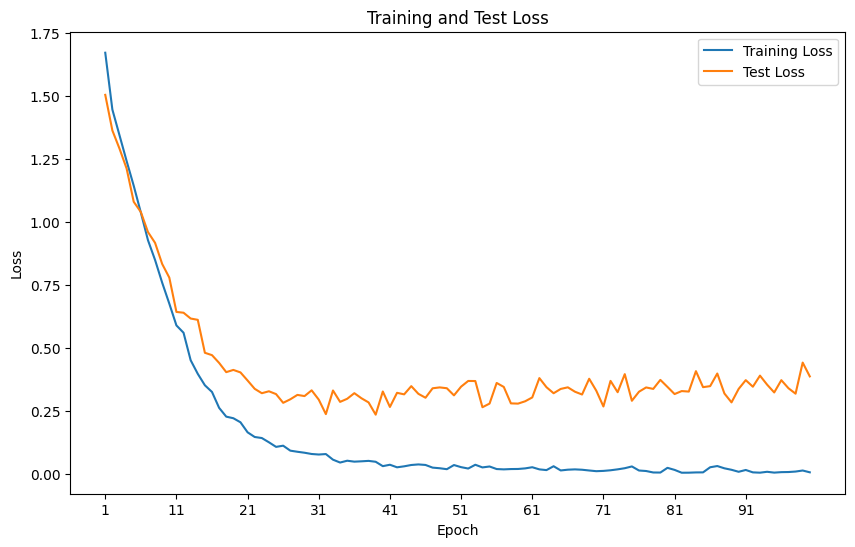

In [70]:
# Final confusion matrix
cm = confusion_matrix(y_true, y_pred)  # Compute the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=CLASSES, yticklabels=CLASSES)  # Create a heatmap for the confusion matrix
plt.xlabel('Predicted')  
plt.ylabel('True') 
plt.title('Confusion Matrix - Final') 
plt.show()  

# Accuracy and loss plots
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_acc_history, label='Training Accuracy')  # Plot training accuracy
plt.plot(range(1, NUM_EPOCHS + 1), test_acc_history, label='Test Accuracy')  # Plot test accuracy
plt.xlabel('Epoch')  
plt.ylabel('Accuracy (%)') 
plt.title('Training and Test Accuracy') 
plt.legend()  
plt.xticks(range(1, NUM_EPOCHS + 1, 10))  
plt.grid(False)  
plt.show()  

plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_loss_history, label='Training Loss')  # Plot training loss
plt.plot(range(1, NUM_EPOCHS + 1), test_loss_history, label='Test Loss')  # Plot test loss
plt.xlabel('Epoch')  
plt.ylabel('Loss')  
plt.title('Training and Test Loss')  
plt.legend() 
plt.xticks(range(1, NUM_EPOCHS + 1, 10)) 
plt.grid(False)  
plt.show()  


The plot_images_predictions function evaluates a trained image classification model by displaying a set number of test images alongside their predicted and true labels. It ensures the model is in evaluation mode to maintain consistency during prediction. This visual assessment helps in understanding how accurately the model identifies objects in new images.

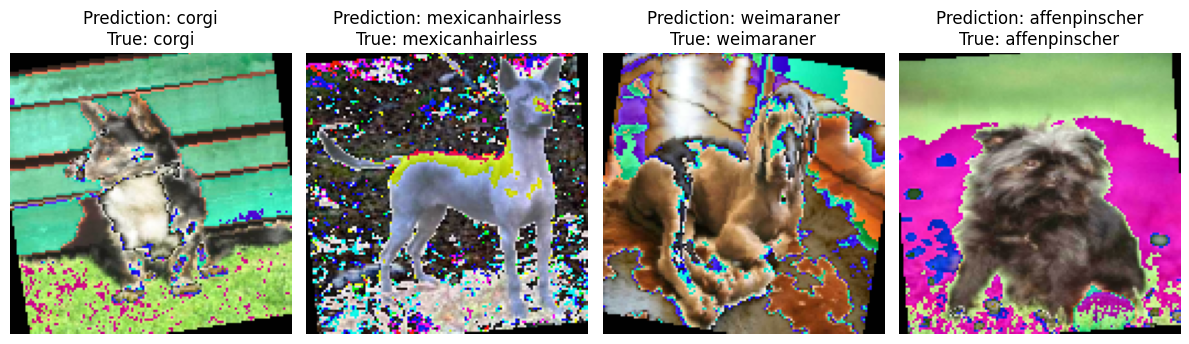

In [71]:
# Function to display images with labels and predictions
def plot_images_predictions(testloader, model, device, classes, num_images=4):
    model.eval()  # Set the model to evaluation mode
    
    # Get a batch of test data
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    
    # Move the images to the device
    images = images.to(device)
    
    # Predict the outputs
    with torch.no_grad():  # Disable gradient computation
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Prepare the visualization of images and predictions
    fig = plt.figure(figsize=(12, 8))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        image = images[i].cpu()  # Move the image to the CPU for plotting
        image = transforms.ToPILImage()(image)  # Convert to PIL image
        plt.imshow(image)
        ax.set_title(f'Prediction: {classes[predicted[i].item()]}\nTrue: {classes[labels[i].item()]}')  # Display prediction and true label
        ax.axis('off')  # Remove axis
    
    plt.tight_layout()  # Adjust the layout to fit everything nicely
    plt.show()  # Show the plot

# Use the function to plot images and predictions
plot_images_predictions(testloader, model, device, CLASSES)



### Used of a training model

In order to use a trained deep learning model to predict the class of a single image. It starts by loading an image from a specified file path using the Python Imaging Library (PIL). Then, the image undergoes the same transformations that before, including resizing to 128x128 pixels, conversion to a tensor format suitable for deep learning models, and normalization of pixel values.

After preprocessing, the image tensor is passed through the deep learning model that has been previously trained for image classification tasks. This model predicts the most likely class label for the input image. 

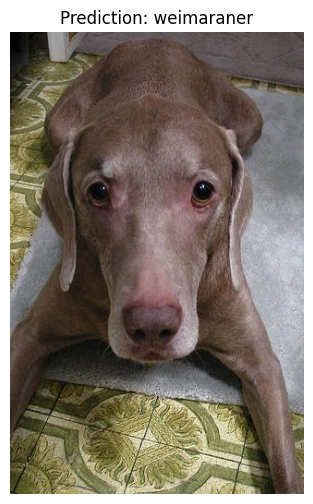

In [72]:
from PIL import Image

# Path to the image
image_path = r"test/weimaraner/weimaraner_3.jpg"

# Define transformations for the image
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to 128x128 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,), (0.5,))  # Normalize the image tensor
])

# Load and process the image
image = Image.open(image_path) 
image_tensor = transform(image).unsqueeze(0)  # Apply transformations and add a batch dimension (1 image)

# Move the image tensor to the GPU 
image_tensor = image_tensor.to(device)

# Get the model's prediction for the image
with torch.no_grad():  # Disable gradient computation
    output = model(image_tensor)  # Forward pass
    _, predicted = torch.max(output, 1)  

# Display the image and the prediction
plt.figure(figsize=(6, 6))
plt.imshow(image)  # Show the original image
plt.title(f'Prediction: {CLASSES[predicted.item()]}')  
plt.axis('off')  
plt.show()  


In [ ]:
CLASSES

['affenpinscher', 'corgi', 'lhasa', 'mexicanhairless', 'setter', 'weimaraner']

In [73]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [74]:
import os
import random
import glob


In [76]:
from torchviz import make_dot
import matplotlib.image as mpimg


### The architecture of the CNN

This process provides a visual overview of the neural network architecture, illustrating how data flows through the layers from input to output. It's particularly useful for understanding the structure of complex models and debugging network connections.

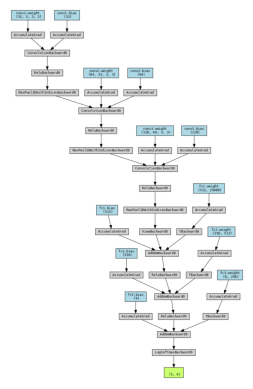

In [79]:
# Create an example tensor to pass through the network
example_input = torch.randn(3, 3, 128, 128).to(device)  # Generate a random tensor with the shape (1, 3, 50, 50) and move it to the device

# Get the model output with the example tensor
model = ImageMulticlassClassificationNet().to(device)  # Instantiate the model and move it to the device
model.eval()  # Set the model to evaluation mode
example_output = model(example_input)  # Forward pass with the example input

# Visualize the neural network graph
dot = make_dot(example_output, params=dict(model.named_parameters()))  # Create a graph of the model

# Adjust the size and style of the graph
dot.attr(size='15,15')  # Set the size of the graph
dot.attr(rankdir='TB')  # Set the direction of the layout (Top-Bottom)
dot.attr(fontsize='12')  # Set the font size

# Save the graph as an image 'model_graph.png' and display it
dot.render('model_graph', format='png')  #
# Load the image and display it
image = mpimg.imread('model_graph.png')  
plt.imshow(image)  
plt.axis('off') 
plt.show()

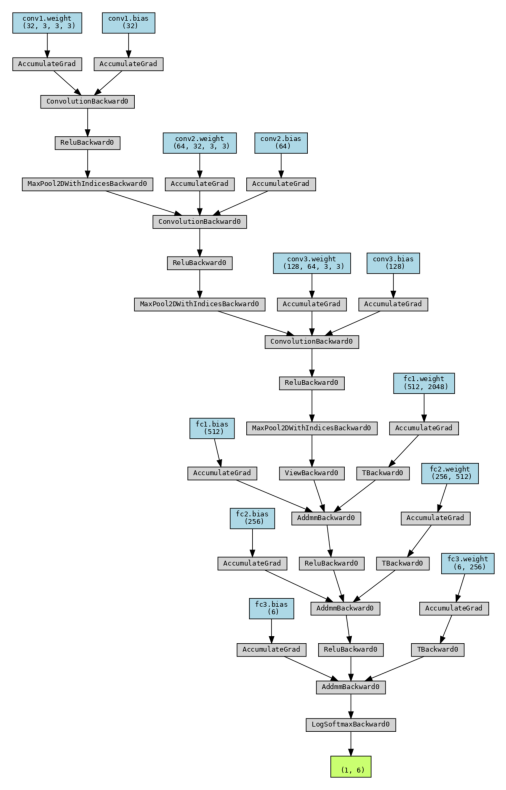

In [ ]:

# Cargar la imagen y mostrarla
image = mpimg.imread('model_graph.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

## Conclutions

* The training accuracy starts at 98.93% and steadily improves, reaching a peak of 99.93%. The training loss begins at 0.0355 and generally decreases over time, indicating effective learning from the training data.

* Testing accuracy begins at 94.67% and fluctuates but generally improves, peaking at 96.17%. Testing loss, starting higher than training loss at 0.3486, decreases over time with some variability, indicating that the model performs well on unseen data.

* Initially, there's a gap between training and testing accuracies, suggesting some overfitting. However, this gap diminishes over epochs, indicating improved generalization of the model.

* The learning rate (lr=0.0001) appears appropriate, supporting stable convergence of the model without significant oscillations in accuracy or loss. The Adam optimizer effectively optimizes the model parameters, contributing to consistent improvements in accuracy and loss.

* By epoch 100, the model achieves a testing accuracy of 95.50%, demonstrating its ability to classify images in the test set accurately. The testing loss (0.3872) is relatively low, indicating good predictive performance without severe overfitting.

* The model demonstrates promising results with high accuracy and effective learning from the training data, showing good generalization to unseen data. This suggests it is well-suited for practical applications in image classification.